<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: NIRISS, image2, assign_wcs

<span style="color:red"> **Instruments Affected**</span>: NIRISS

### Table of Contents
<div style="text-align: left"> 
    
<br> [Introduction](#intro)
<br> [JWST CalWG Algorithm](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description](#description)
<br> [Data Description](#data_descr)
<br> [Imports](#imports)
<br> [Loading the Data](#data_load)
<br> [Run the Pipeline](#pipeline)
<br> [Perform Tests](#testing) 
<br> [About This Notebook](#about)
<br>    

</div>

<a id="intro"></a>
# Introduction

This is the validation notebook for the assign_wcs step in the image2 stage of the pipeline. The validation step does two checks: 
1. Round trip conversion between coordinate systems to test whether the output matches the input; 
2. Conversion from sky coordinates to detector coordinates for a catalog of sources to assess whether the originally inputted detector coordinates are recovered.

For more information on the pipeline step visit the links below. 

> Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html 

> Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/assign_wcs

[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm

A description of the assign_wcs algorithm from the JWST CalWG: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Imaging+GWCS+Information

[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms

GWCS: Generalized World Coordinate System

V1, V2, V3: Defines Observatory Coordinate System (see Figure 1 on [JWST Position Angles, Ranges, and Offsets JDox article](https://jwst-docs.stsci.edu/jwst-observatory-functionality/jwst-position-angles-ranges-and-offsets))

[Top of Page](#title_ID)

<a id="description"></a>
# Test Description
- Calibrate data through Detector1 stage of the pipeline.
- **Round trip conversion test** - check the level of agreement between the input and output values of the following coordinate systems:
    - World --> Detector --> World
    - Detector --> World --> Detector
    - World --> V2 V3 --> World
    - Detector --> V2 V3 --> Detector
- **Round trip conversion test** is done for two sets of input coordinates:
    - Reference pixels at which the transform is anchored:
        - crpix1, crpix2 (detector units)
        - crval1, crval2 (world coordinate system units)
    - Coordinates at the edge of the input subarray:
        - xpix=10, ypix=10
    - The tolerance for pass/fail (fractional difference between input and output values) is stricter for transforms at the reference pixels compared with the edge of the subarray. For the reference pixel test, the tolerance is stricter for full frame readout compared with subarrays. The tolerances can be updated in the code. Currently, they are set to the following:
        - tolerance reference pixel, full frame: 1e-4
        - tolerance reference pixel, subarray: 1e-3
        - tolerance edge of subarray: 1e-2
- **Input source catalog test** - use an input list of sources arranged along a grid that have known input detector coordinates from a Mirage simulation. The simulation produces a catalog of sources with world coordinate system units (i.e., RA and Dec). The test converts these coordinates to detector units and produces the following:
    - Calculations $\Delta$x and $\Delta$y (difference between input and output pixels) for each source and RMS$_{\Delta x}$ and RMS $_{\Delta y}$;
    - Histograms of $\Delta$x and $\Delta$y for inspection;
    - Plots of $\Delta$x as function of x position and $\Delta$y as function of y position for inspection;
    - The pass/fail test: is RMS$_{\Delta x}$ and RMS$_{\Delta y}$ within the tolerance? The tolerance can be updated in the code. Currently, it is set to 1e-2 pixels.


[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description
All data were generated with [MIRaGe](https://github.com/spacetelescope/mirage) version 1.3.3 on date May 25, 2021

**Round trip conversion test**: 10 blank field simulations (spanning a range of RAs and Decs) with all available subarray options:
- CLEAR/F200W SUB128
- CLEAR/F200W SUB256
- CLEAR/F200W SUB64
- CLEAR/F200W SUB80
- CLEAR/F200W WFSS128C
- CLEAR/F200W WFSS128R 
- CLEAR/F200W WFSS64C
- CLEAR/F200W WFSS64R
- F480M/NRM FULL
- F480/NRM SUB80

This test also includes the simulation in the below **Input source catalog test**.

**Input source catalog test**: Simulation of a grid of 50 sources with Clear/F200W combination, full frame readout. MIRaGe catalog (`*_pointsources.list`) is also needed.

Data are stored in temporary directory which is created below.    

[Top of Page](#title_ID)

In [1]:
use_tempdir = True

# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil

if use_tempdir:
    data_dir = TemporaryDirectory()

    # Save original directory
    orig_dir = os.getcwd()

    # Move to new directory
    outdir = data_dir.name
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j


In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


<a id="imports"></a>
# Imports

* astropy.io for opening fits and ascii files
* glob for retrieving fits files
* numpy for mathematical computation
* ci_watson.artifactory_helpers to read in simulations from artifactory
* jwst pipeline steps to process data through stage 1 of the pipeline, use image data model, and access convenience functions in from AssignWcsStep
* matplotlib.pyplot.plt to generate plots

[Top of Page](#title_ID)

In [3]:
from astropy.io import fits,ascii
import glob
import numpy as np
from ci_watson.artifactory_helpers import get_bigdata
from jwst.pipeline import calwebb_detector1
from jwst.assign_wcs import AssignWcsStep
from jwst.datamodels import image
import matplotlib.pyplot as plt

<a id="data_load"></a>
# Loading the Data

Data are stored on Artifactory. The list of simulated datasets and the Mirage catalog list are provided below. The simulated datasets are ready in when running the pipeline to process the data.

[Top of Page](#title_ID)

In [4]:
# Create list of simulated data files:
sim_files = np.array(['jw00042001001_01101_00001_nis_uncal.fits',
                      'jw00042002001_01101_00001_nis_uncal.fits',
                      'jw00042003001_01101_00001_nis_uncal.fits',
                      'jw00042004001_01101_00001_nis_uncal.fits',
                      'jw00042005001_01101_00001_nis_uncal.fits',
                      'jw00042006001_01101_00001_nis_uncal.fits',
                      'jw00042007001_01101_00001_nis_uncal.fits',
                      'jw00042008001_01101_00001_nis_uncal.fits',
                      'jw00042009001_01101_00001_nis_uncal.fits',
                      'jw00042010001_01101_00001_nis_uncal.fits',
                      'jw00042011001_01101_00001_nis_uncal.fits'])

# read MIRaGe's point source list from Artifactory
ptsrc_list_f = get_bigdata('jwst_validation_notebooks',
                           'validation_data',
                           'assign_wcs',
                           'assign_wcs_niriss_test',
                           'jw00042001001_01101_00001_nis_uncal_pointsources.list')

<a id="pipeline"></a>
# Run Detector 1 Stage of the Pipeline 

Run simulations through calwebb_detector1 to produce rate images to test assign_wcs step  

[Top of Page](#title_ID)

In [5]:
# Initialize Detector 1 stage
det1 = calwebb_detector1.Detector1Pipeline()
det1.save_results = True
det1.output_dir = outdir

# Run pipeline on simulations to produce *_rate.fits files

for sfile in sim_files:
    
    # strip out prefix of file name to use for output file
    prefix = (sfile.split('uncal')[0])#.split('/')[-1]
    det1.output_file = prefix+'rate.fits'

    # Read in the data files from Artifactory
    uncal_file = get_bigdata('jwst_validation_notebooks',
                             'validation_data',
                             'assign_wcs',
                             'assign_wcs_niriss_test',
                             sfile)

    # Run pipeline

    det1.run(uncal_file)

2022-03-22 15:36:47,017 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-03-22 15:36:47,019 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-03-22 15:36:47,020 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-03-22 15:36:47,021 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-03-22 15:36:47,022 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-03-22 15:36:47,024 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-03-22 15:36:47,025 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-03-22 15:36:47,026 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-03-22 15:36:47,027 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-03-22 15:36:47,028 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-03-22 15:36:47,029 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-03-22 15:36:47,030 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-03-22 15:36:47,031 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-03-22 15:36:47,032 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-03-22 15:36:47,034 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-03-22 15:36:47,035 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-03-22 15:36:47,036 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-03-22 15:36:48,172 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042001001_01101_00001_nis_uncal.fits',).


2022-03-22 15:36:48,181 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042001001_01101_00001_nis_rate.fits', 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.f

2022-03-22 15:36:49,167 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042001001_01101_00001_nis_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-03-22 15:36:50,467 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_dark_0148.fits'.


2022-03-22 15:36:50,468 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0002.fits'.


2022-03-22 15:36:50,470 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits'.


2022-03-22 15:36:50,472 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits'.


2022-03-22 15:36:50,473 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.


2022-03-22 15:36:50,474 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.


2022-03-22 15:36:50,476 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.


2022-03-22 15:36:50,478 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-03-22 15:36:50,478 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-03-22 15:36:50,479 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-03-22 15:36:50,479 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits'.


2022-03-22 15:36:50,480 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0151.fits'.


2022-03-22 15:36:50,482 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.


2022-03-22 15:36:50,483 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.


2022-03-22 15:36:50,484 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-03-22 15:36:50,841 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:36:50,843 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:36:50,970 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=4 is a power of 2; correction not needed


2022-03-22 15:36:50,970 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-03-22 15:36:50,973 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-03-22 15:36:51,065 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:36:51,066 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:36:51,089 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits


2022-03-22 15:36:51,574 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-03-22 15:36:51,665 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:36:51,666 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:36:51,687 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits


2022-03-22 15:36:51,888 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:36:52,247 - stpipe.Detector1Pipeline.saturation - INFO - Detected 462 saturated pixels


2022-03-22 15:36:52,276 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-03-22 15:36:52,294 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-03-22 15:36:52,396 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:36:52,397 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:36:52,417 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits


2022-03-22 15:36:56,420 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-03-22 15:36:56,512 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:36:56,513 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:36:56,535 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_niriss_superbias_0151.fits


2022-03-22 15:36:58,733 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-03-22 15:36:58,838 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:36:58,839 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-03-22 15:36:58,848 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-03-22 15:36:58,848 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-03-22 15:36:58,849 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-03-22 15:36:58,849 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-03-22 15:36:58,850 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-03-22 15:37:01,132 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-03-22 15:37:01,226 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:01,227 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:37:01,249 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits


2022-03-22 15:37:01,806 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword OCCULTING does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:37:02,445 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-03-22 15:37:02,543 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:02,545 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2022-03-22 15:37:05,241 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042001001_01101_00001_nis_trapsfilled.fits


2022-03-22 15:37:05,248 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2022-03-22 15:37:05,372 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:05,373 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'dark_output': None}


2022-03-22 15:37:05,394 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_niriss_dark_0148.fits


2022-03-22 15:37:11,799 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=4, groupgap=0


2022-03-22 15:37:11,800 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=25, nframes=4, groupgap=0


2022-03-22 15:37:12,168 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-03-22 15:37:12,262 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:12,264 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-03-22 15:37:12,273 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-03-22 15:37:12,285 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0002.fits


2022-03-22 15:37:12,958 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:37:13,890 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-03-22 15:37:13,941 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-03-22 15:37:15,813 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:116: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-03-22 15:37:15,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39722 pixels with at least one CR from five groups.


2022-03-22 15:37:15,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6 pixels with at least one CR from four groups.


2022-03-22 15:37:15,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8 pixels with at least one CR from three groups.


2022-03-22 15:37:21,090 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.19918 sec


2022-03-22 15:37:21,093 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.820400


2022-03-22 15:37:21,099 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-03-22 15:37:21,201 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:21,202 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2022-03-22 15:37:21,234 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:37:21,235 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0002.fits


2022-03-22 15:37:21,306 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-03-22 15:37:21,307 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-03-22 15:37:37,214 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1155: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)



2022-03-22 15:37:37,930 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 5


2022-03-22 15:37:37,931 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-03-22 15:37:38,103 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-03-22 15:37:38,228 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:38,230 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:37:38,275 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:37:38,276 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:37:38,280 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:37:38,376 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:38,378 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:37:38,422 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:37:38,422 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:37:38,427 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:37:38,552 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042001001_01101_00001_nis_rateints.fits


2022-03-22 15:37:38,554 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-03-22 15:37:38,673 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042001001_01101_00001_nis_rate.fits


2022-03-22 15:37:38,674 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-03-22 15:37:39,466 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042002001_01101_00001_nis_uncal.fits',).


2022-03-22 15:37:39,475 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042002001_01101_00001_nis_rate.fits', 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir':

2022-03-22 15:37:39,684 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042002001_01101_00001_nis_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-03-22 15:37:39,695 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_dark_0145.fits'.


2022-03-22 15:37:39,696 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0002.fits'.


2022-03-22 15:37:39,697 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits'.


2022-03-22 15:37:39,698 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits'.


2022-03-22 15:37:39,700 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.


2022-03-22 15:37:39,701 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.


2022-03-22 15:37:39,703 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0002.fits'.


2022-03-22 15:37:39,704 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-03-22 15:37:39,705 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-03-22 15:37:39,705 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-03-22 15:37:39,705 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits'.


2022-03-22 15:37:39,707 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0150.fits'.


2022-03-22 15:37:39,708 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.


2022-03-22 15:37:39,709 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.


2022-03-22 15:37:39,711 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-03-22 15:37:40,022 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 2048, 2048) from jw00042002001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:40,023 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:37:40,121 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-03-22 15:37:40,122 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-03-22 15:37:40,124 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-03-22 15:37:40,219 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 2048, 2048) from jw00042002001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:40,221 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:37:40,241 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits


2022-03-22 15:37:40,666 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-03-22 15:37:40,762 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 2048, 2048) from jw00042002001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:40,763 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:37:40,783 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits


2022-03-22 15:37:40,863 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:37:41,157 - stpipe.Detector1Pipeline.saturation - INFO - Detected 114 saturated pixels


2022-03-22 15:37:41,180 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1 A/D floor pixels


2022-03-22 15:37:41,191 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-03-22 15:37:41,288 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 2048, 2048) from jw00042002001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:41,289 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:37:41,309 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits


2022-03-22 15:37:42,392 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-03-22 15:37:42,491 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 2048, 2048) from jw00042002001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:42,492 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'superbias', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:37:42,514 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_niriss_superbias_0150.fits


2022-03-22 15:37:43,499 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-03-22 15:37:43,596 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 2048, 2048) from jw00042002001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:43,597 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-03-22 15:37:43,606 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-03-22 15:37:43,607 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-03-22 15:37:43,607 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-03-22 15:37:43,607 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-03-22 15:37:43,608 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-03-22 15:37:45,614 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-03-22 15:37:45,723 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 2048, 2048) from jw00042002001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:45,725 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:37:45,747 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits


2022-03-22 15:37:45,883 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword OCCULTING does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:37:46,482 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-03-22 15:37:46,584 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 2048, 2048) from jw00042002001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:46,585 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'input_trapsfilled': None, 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2022-03-22 15:37:49,113 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042002001_01101_00001_nis_trapsfilled.fits


2022-03-22 15:37:49,119 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2022-03-22 15:37:49,221 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 2048, 2048) from jw00042002001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:37:49,222 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'dark_output': None}


2022-03-22 15:37:49,244 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_niriss_dark_0145.fits


2022-03-22 15:38:14,559 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2022-03-22 15:38:14,559 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=100, nframes=1, groupgap=0


2022-03-22 15:38:15,298 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-03-22 15:38:15,413 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 2048, 2048) from jw00042002001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:15,415 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-03-22 15:38:15,424 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-03-22 15:38:15,436 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0002.fits


2022-03-22 15:38:15,475 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0002.fits


2022-03-22 15:38:16,332 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-03-22 15:38:16,382 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-03-22 15:38:18,271 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:116: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-03-22 15:38:18,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16947 pixels with at least one CR from five groups.


2022-03-22 15:38:18,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2 pixels with at least one CR from four groups.


2022-03-22 15:38:18,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9 pixels with at least one CR from three groups.


2022-03-22 15:38:20,567 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.23435 sec


2022-03-22 15:38:20,570 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 5.146333


2022-03-22 15:38:20,575 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-03-22 15:38:20,674 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 2048, 2048) from jw00042002001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:20,675 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2022-03-22 15:38:20,707 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0002.fits


2022-03-22 15:38:20,707 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0002.fits


2022-03-22 15:38:20,766 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-03-22 15:38:20,767 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-03-22 15:38:36,152 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1155: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)



2022-03-22 15:38:36,958 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 5


2022-03-22 15:38:36,959 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-03-22 15:38:37,153 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-03-22 15:38:37,252 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from jw00042002001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:37,254 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:38:37,298 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:38:37,298 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:38:37,303 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:38:37,406 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw00042002001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:37,408 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:38:37,453 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:38:37,454 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:38:37,459 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:38:37,587 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042002001_01101_00001_nis_rateints.fits


2022-03-22 15:38:37,589 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-03-22 15:38:37,711 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042002001_01101_00001_nis_rate.fits


2022-03-22 15:38:37,712 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-03-22 15:38:39,901 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042003001_01101_00001_nis_uncal.fits',).


2022-03-22 15:38:39,910 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042003001_01101_00001_nis_rate.fits', 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir':

2022-03-22 15:38:40,120 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042003001_01101_00001_nis_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-03-22 15:38:40,139 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_dark_0145.fits'.


2022-03-22 15:38:40,141 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0002.fits'.


2022-03-22 15:38:40,143 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits'.


2022-03-22 15:38:40,146 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits'.


2022-03-22 15:38:40,148 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.


2022-03-22 15:38:40,150 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.


2022-03-22 15:38:40,152 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0002.fits'.


2022-03-22 15:38:40,154 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-03-22 15:38:40,154 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-03-22 15:38:40,155 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-03-22 15:38:40,155 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits'.


2022-03-22 15:38:40,157 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0150.fits'.


2022-03-22 15:38:40,158 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.


2022-03-22 15:38:40,160 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.


2022-03-22 15:38:40,161 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-03-22 15:38:40,460 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 2048, 2048) from jw00042003001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:40,462 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:38:40,559 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-03-22 15:38:40,560 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-03-22 15:38:40,562 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-03-22 15:38:40,658 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 2048, 2048) from jw00042003001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:40,660 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:38:40,680 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits


2022-03-22 15:38:41,103 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-03-22 15:38:41,200 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 2048, 2048) from jw00042003001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:41,201 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:38:41,221 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits


2022-03-22 15:38:41,299 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:38:41,577 - stpipe.Detector1Pipeline.saturation - INFO - Detected 79 saturated pixels


2022-03-22 15:38:41,596 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1 A/D floor pixels


2022-03-22 15:38:41,608 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-03-22 15:38:41,706 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 2048, 2048) from jw00042003001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:41,707 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:38:41,728 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits


2022-03-22 15:38:42,813 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-03-22 15:38:42,914 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 2048, 2048) from jw00042003001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:42,915 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'superbias', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:38:42,937 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_niriss_superbias_0150.fits


2022-03-22 15:38:43,178 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-03-22 15:38:43,282 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 2048, 2048) from jw00042003001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:43,284 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-03-22 15:38:43,293 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-03-22 15:38:43,294 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-03-22 15:38:43,294 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-03-22 15:38:43,294 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-03-22 15:38:43,295 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-03-22 15:38:45,526 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-03-22 15:38:45,626 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 2048, 2048) from jw00042003001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:45,627 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:38:45,647 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits


2022-03-22 15:38:45,778 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword OCCULTING does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:38:46,369 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-03-22 15:38:46,472 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 2048, 2048) from jw00042003001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:46,473 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'input_trapsfilled': None, 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2022-03-22 15:38:48,984 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042003001_01101_00001_nis_trapsfilled.fits


2022-03-22 15:38:48,989 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2022-03-22 15:38:49,092 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 2048, 2048) from jw00042003001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:49,093 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'dark_output': None}


2022-03-22 15:38:49,114 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_niriss_dark_0145.fits


2022-03-22 15:38:50,461 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2022-03-22 15:38:50,462 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=100, nframes=1, groupgap=0


2022-03-22 15:38:51,185 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-03-22 15:38:51,306 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 2048, 2048) from jw00042003001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:51,307 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-03-22 15:38:51,317 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-03-22 15:38:51,328 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0002.fits


2022-03-22 15:38:51,365 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0002.fits


2022-03-22 15:38:51,576 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-03-22 15:38:51,622 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-03-22 15:38:53,510 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:116: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-03-22 15:38:53,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17545 pixels with at least one CR from five groups.


2022-03-22 15:38:53,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3 pixels with at least one CR from four groups.


2022-03-22 15:38:53,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6 pixels with at least one CR from three groups.


2022-03-22 15:38:55,916 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.33963 sec


2022-03-22 15:38:55,919 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.602894


2022-03-22 15:38:55,925 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-03-22 15:38:56,028 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 2048, 2048) from jw00042003001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:38:56,029 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2022-03-22 15:38:56,062 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0002.fits


2022-03-22 15:38:56,063 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0002.fits


2022-03-22 15:38:56,124 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-03-22 15:38:56,124 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-03-22 15:39:11,827 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1155: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)



2022-03-22 15:39:12,647 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 5


2022-03-22 15:39:12,648 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-03-22 15:39:12,848 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-03-22 15:39:12,965 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from jw00042003001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:12,967 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:13,008 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:39:13,009 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:39:13,013 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:39:13,114 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw00042003001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:13,115 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:13,161 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:39:13,161 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:39:13,166 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:39:13,290 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042003001_01101_00001_nis_rateints.fits


2022-03-22 15:39:13,292 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-03-22 15:39:13,411 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042003001_01101_00001_nis_rate.fits


2022-03-22 15:39:13,411 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-03-22 15:39:13,627 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042004001_01101_00001_nis_uncal.fits',).


2022-03-22 15:39:13,638 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042004001_01101_00001_nis_rate.fits', 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir':

2022-03-22 15:39:13,784 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042004001_01101_00001_nis_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-03-22 15:39:13,797 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_dark_0115.fits'.


2022-03-22 15:39:13,798 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits'.


2022-03-22 15:39:13,800 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits'.


2022-03-22 15:39:13,801 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits'.


2022-03-22 15:39:13,803 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.


2022-03-22 15:39:13,804 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.


2022-03-22 15:39:13,805 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.


2022-03-22 15:39:13,806 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-03-22 15:39:13,807 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-03-22 15:39:13,807 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-03-22 15:39:13,807 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits'.


2022-03-22 15:39:13,809 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0154.fits'.


2022-03-22 15:39:13,810 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.


2022-03-22 15:39:13,811 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.


2022-03-22 15:39:13,812 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-03-22 15:39:14,046 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 64, 64) from jw00042004001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:14,047 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:14,085 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=4 is a power of 2; correction not needed


2022-03-22 15:39:14,085 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-03-22 15:39:14,088 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-03-22 15:39:14,186 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 64, 64) from jw00042004001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:14,188 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:14,209 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits


2022-03-22 15:39:14,530 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2022-03-22 15:39:14,544 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-03-22 15:39:14,646 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 64, 64) from jw00042004001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:14,648 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:14,668 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits


2022-03-22 15:39:14,749 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:39:14,781 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2022-03-22 15:39:14,792 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-03-22 15:39:14,793 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-03-22 15:39:14,799 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-03-22 15:39:14,903 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 64, 64) from jw00042004001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:14,904 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:14,925 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits


2022-03-22 15:39:15,018 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-03-22 15:39:15,122 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 64, 64) from jw00042004001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:15,123 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'superbias', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:15,144 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_niriss_superbias_0154.fits


2022-03-22 15:39:15,231 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-03-22 15:39:15,339 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 64, 64) from jw00042004001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:15,340 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-03-22 15:39:15,350 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-03-22 15:39:15,350 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-03-22 15:39:15,350 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-03-22 15:39:15,351 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-03-22 15:39:15,351 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-03-22 15:39:15,440 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-03-22 15:39:15,544 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 64, 64) from jw00042004001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:15,545 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:15,565 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits


2022-03-22 15:39:15,684 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword OCCULTING does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:39:15,732 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-03-22 15:39:15,837 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 64, 64) from jw00042004001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:15,839 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'input_trapsfilled': None, 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2022-03-22 15:39:16,466 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042004001_01101_00001_nis_trapsfilled.fits


2022-03-22 15:39:16,472 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2022-03-22 15:39:16,574 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 64, 64) from jw00042004001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:16,575 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'dark_output': None}


2022-03-22 15:39:16,596 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_niriss_dark_0115.fits


2022-03-22 15:39:16,668 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=4, groupgap=0


2022-03-22 15:39:16,669 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=50, nframes=1, groupgap=0


2022-03-22 15:39:16,706 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-03-22 15:39:16,811 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 64, 64) from jw00042004001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:16,813 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-03-22 15:39:16,823 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-03-22 15:39:16,836 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:39:16,909 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:39:16,979 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2022-03-22 15:39:16,980 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:39:16,980 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-03-22 15:39:16,981 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-03-22 15:39:16,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 84 pixels with at least one CR from five groups.


2022-03-22 15:39:16,984 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-03-22 15:39:16,984 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-03-22 15:39:16,995 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.0139806 sec


2022-03-22 15:39:16,997 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.174568


2022-03-22 15:39:17,002 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-03-22 15:39:17,109 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 64, 64) from jw00042004001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:17,110 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2022-03-22 15:39:17,146 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:39:17,147 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:39:17,218 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2022-03-22 15:39:17,219 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:39:17,220 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-03-22 15:39:17,221 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-03-22 15:39:17,237 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 5


2022-03-22 15:39:17,237 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-03-22 15:39:17,301 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-03-22 15:39:17,412 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(64, 64) from jw00042004001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:17,414 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:17,458 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:39:17,458 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:39:17,463 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:39:17,568 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 64, 64) from jw00042004001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:17,569 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:17,615 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:39:17,616 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:39:17,620 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:39:17,685 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042004001_01101_00001_nis_rateints.fits


2022-03-22 15:39:17,686 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-03-22 15:39:17,740 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042004001_01101_00001_nis_rate.fits


2022-03-22 15:39:17,741 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-03-22 15:39:18,047 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042005001_01101_00001_nis_uncal.fits',).


2022-03-22 15:39:18,057 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042005001_01101_00001_nis_rate.fits', 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir':

2022-03-22 15:39:18,194 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042005001_01101_00001_nis_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-03-22 15:39:18,202 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_dark_0116.fits'.


2022-03-22 15:39:18,204 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits'.


2022-03-22 15:39:18,205 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits'.


2022-03-22 15:39:18,206 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits'.


2022-03-22 15:39:18,207 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.


2022-03-22 15:39:18,208 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.


2022-03-22 15:39:18,209 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.


2022-03-22 15:39:18,210 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-03-22 15:39:18,210 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-03-22 15:39:18,211 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-03-22 15:39:18,211 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits'.


2022-03-22 15:39:18,212 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0146.fits'.


2022-03-22 15:39:18,215 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.


2022-03-22 15:39:18,216 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.


2022-03-22 15:39:18,218 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-03-22 15:39:18,559 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 80, 80) from jw00042005001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:18,560 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:18,600 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=4 is a power of 2; correction not needed


2022-03-22 15:39:18,601 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-03-22 15:39:18,603 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-03-22 15:39:18,795 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 80, 80) from jw00042005001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:18,797 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:18,819 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits


2022-03-22 15:39:19,198 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2022-03-22 15:39:19,213 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-03-22 15:39:19,419 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 80, 80) from jw00042005001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:19,421 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:19,442 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits


2022-03-22 15:39:19,539 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:39:19,574 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2022-03-22 15:39:19,584 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-03-22 15:39:19,585 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-03-22 15:39:19,591 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-03-22 15:39:19,801 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 80, 80) from jw00042005001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:19,803 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:19,824 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits


2022-03-22 15:39:19,923 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-03-22 15:39:20,125 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 80, 80) from jw00042005001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:20,127 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'superbias', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:20,148 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_niriss_superbias_0146.fits


2022-03-22 15:39:20,228 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-03-22 15:39:20,422 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 80, 80) from jw00042005001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:20,423 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-03-22 15:39:20,433 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-03-22 15:39:20,433 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-03-22 15:39:20,434 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-03-22 15:39:20,434 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-03-22 15:39:20,435 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-03-22 15:39:20,528 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-03-22 15:39:20,733 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 80, 80) from jw00042005001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:20,734 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:20,756 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits


2022-03-22 15:39:20,899 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword OCCULTING does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:39:20,950 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-03-22 15:39:21,157 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 80, 80) from jw00042005001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:21,159 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'input_trapsfilled': None, 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2022-03-22 15:39:21,909 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042005001_01101_00001_nis_trapsfilled.fits


2022-03-22 15:39:21,914 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2022-03-22 15:39:22,120 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 80, 80) from jw00042005001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:22,122 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'dark_output': None}


2022-03-22 15:39:22,144 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_niriss_dark_0116.fits


2022-03-22 15:39:23,211 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=4, groupgap=0


2022-03-22 15:39:23,211 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=800, nframes=1, groupgap=0


2022-03-22 15:39:23,256 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-03-22 15:39:23,455 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 80, 80) from jw00042005001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:23,456 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-03-22 15:39:23,466 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-03-22 15:39:23,480 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:39:23,519 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:39:23,592 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2022-03-22 15:39:23,593 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:39:23,595 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-03-22 15:39:23,596 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-03-22 15:39:23,600 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 79 pixels with at least one CR from five groups.


2022-03-22 15:39:23,600 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-03-22 15:39:23,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-03-22 15:39:23,614 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.0185468 sec


2022-03-22 15:39:23,616 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.149995


2022-03-22 15:39:23,622 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-03-22 15:39:23,829 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 80, 80) from jw00042005001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:23,831 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2022-03-22 15:39:23,865 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:39:23,865 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:39:23,941 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2022-03-22 15:39:23,942 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:39:23,943 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-03-22 15:39:23,943 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-03-22 15:39:23,970 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 5


2022-03-22 15:39:23,970 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-03-22 15:39:24,035 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-03-22 15:39:24,170 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(80, 80) from jw00042005001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:24,171 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:24,216 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:39:24,217 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:39:24,222 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:39:24,332 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 80, 80) from jw00042005001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:24,333 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:24,378 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:39:24,379 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:39:24,383 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:39:24,446 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042005001_01101_00001_nis_rateints.fits


2022-03-22 15:39:24,448 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-03-22 15:39:24,501 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042005001_01101_00001_nis_rate.fits


2022-03-22 15:39:24,502 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-03-22 15:39:24,732 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042006001_01101_00001_nis_uncal.fits',).


2022-03-22 15:39:24,741 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042006001_01101_00001_nis_rate.fits', 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir':

2022-03-22 15:39:24,880 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042006001_01101_00001_nis_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-03-22 15:39:24,887 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_dark_0110.fits'.


2022-03-22 15:39:24,888 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits'.


2022-03-22 15:39:24,889 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits'.


2022-03-22 15:39:24,890 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits'.


2022-03-22 15:39:24,891 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.


2022-03-22 15:39:24,891 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.


2022-03-22 15:39:24,892 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.


2022-03-22 15:39:24,893 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-03-22 15:39:24,893 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-03-22 15:39:24,894 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-03-22 15:39:24,894 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits'.


2022-03-22 15:39:24,895 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0149.fits'.


2022-03-22 15:39:24,896 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.


2022-03-22 15:39:24,897 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.


2022-03-22 15:39:24,898 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-03-22 15:39:25,145 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 128, 128) from jw00042006001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:25,146 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:25,186 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=4 is a power of 2; correction not needed


2022-03-22 15:39:25,187 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-03-22 15:39:25,190 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-03-22 15:39:25,305 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 128, 128) from jw00042006001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:25,306 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:25,327 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits


2022-03-22 15:39:25,664 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2022-03-22 15:39:25,678 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-03-22 15:39:25,787 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 128, 128) from jw00042006001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:25,788 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:25,809 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits


2022-03-22 15:39:25,891 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:39:25,924 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2022-03-22 15:39:25,935 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-03-22 15:39:25,935 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-03-22 15:39:25,942 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-03-22 15:39:26,051 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 128, 128) from jw00042006001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:26,053 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:26,073 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits


2022-03-22 15:39:26,171 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-03-22 15:39:26,279 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 128, 128) from jw00042006001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:26,281 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'superbias', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:26,301 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_niriss_superbias_0149.fits


2022-03-22 15:39:26,418 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-03-22 15:39:26,530 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 128, 128) from jw00042006001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:26,531 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-03-22 15:39:26,541 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-03-22 15:39:26,541 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-03-22 15:39:26,542 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-03-22 15:39:26,542 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-03-22 15:39:26,542 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-03-22 15:39:26,633 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-03-22 15:39:26,743 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 128, 128) from jw00042006001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:26,745 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:26,765 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits


2022-03-22 15:39:26,897 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword OCCULTING does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:39:26,950 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-03-22 15:39:27,069 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 128, 128) from jw00042006001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:27,071 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'input_trapsfilled': None, 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2022-03-22 15:39:27,725 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042006001_01101_00001_nis_trapsfilled.fits


2022-03-22 15:39:27,731 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2022-03-22 15:39:27,844 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 128, 128) from jw00042006001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:27,845 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'dark_output': None}


2022-03-22 15:39:27,867 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_niriss_dark_0110.fits


2022-03-22 15:39:27,967 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=4, groupgap=0


2022-03-22 15:39:27,968 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=50, nframes=1, groupgap=0


2022-03-22 15:39:28,007 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-03-22 15:39:28,118 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 128, 128) from jw00042006001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:28,120 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-03-22 15:39:28,129 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-03-22 15:39:28,141 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:39:28,179 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:39:28,250 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2022-03-22 15:39:28,251 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:39:28,252 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-03-22 15:39:28,253 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-03-22 15:39:28,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 268 pixels with at least one CR from five groups.


2022-03-22 15:39:28,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-03-22 15:39:28,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-03-22 15:39:28,294 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.0411007 sec


2022-03-22 15:39:28,296 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.167140


2022-03-22 15:39:28,301 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-03-22 15:39:28,409 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 128, 128) from jw00042006001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:28,410 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2022-03-22 15:39:28,442 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:39:28,442 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:39:28,512 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2022-03-22 15:39:28,513 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:39:28,513 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-03-22 15:39:28,514 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-03-22 15:39:28,564 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 5


2022-03-22 15:39:28,565 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-03-22 15:39:28,628 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-03-22 15:39:28,742 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(128, 128) from jw00042006001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:28,743 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:28,787 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:39:28,788 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:39:28,792 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:39:28,898 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 128, 128) from jw00042006001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:28,900 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:28,945 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:39:28,946 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:39:28,950 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:39:29,016 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042006001_01101_00001_nis_rateints.fits


2022-03-22 15:39:29,019 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-03-22 15:39:29,088 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042006001_01101_00001_nis_rate.fits


2022-03-22 15:39:29,089 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-03-22 15:39:29,448 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042007001_01101_00001_nis_uncal.fits',).


2022-03-22 15:39:29,458 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042007001_01101_00001_nis_rate.fits', 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir':

2022-03-22 15:39:29,597 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042007001_01101_00001_nis_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-03-22 15:39:29,604 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_dark_0121.fits'.


2022-03-22 15:39:29,606 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits'.


2022-03-22 15:39:29,608 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits'.


2022-03-22 15:39:29,609 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits'.


2022-03-22 15:39:29,611 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.


2022-03-22 15:39:29,612 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.


2022-03-22 15:39:29,614 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.


2022-03-22 15:39:29,615 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-03-22 15:39:29,616 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-03-22 15:39:29,616 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-03-22 15:39:29,616 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits'.


2022-03-22 15:39:29,618 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0147.fits'.


2022-03-22 15:39:29,619 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.


2022-03-22 15:39:29,621 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.


2022-03-22 15:39:29,623 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-03-22 15:39:29,977 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 256, 256) from jw00042007001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:29,979 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:30,021 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=4 is a power of 2; correction not needed


2022-03-22 15:39:30,022 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-03-22 15:39:30,025 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-03-22 15:39:30,232 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 256, 256) from jw00042007001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:30,233 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:30,254 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits


2022-03-22 15:39:30,627 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2022-03-22 15:39:30,642 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-03-22 15:39:30,853 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 256, 256) from jw00042007001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:30,855 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:30,876 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits


2022-03-22 15:39:30,969 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:39:31,005 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2022-03-22 15:39:31,018 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1 saturated pixels


2022-03-22 15:39:31,019 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-03-22 15:39:31,025 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-03-22 15:39:31,242 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 256, 256) from jw00042007001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:31,244 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:31,265 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits


2022-03-22 15:39:31,372 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-03-22 15:39:31,578 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 256, 256) from jw00042007001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:31,580 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'superbias', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:31,601 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_niriss_superbias_0147.fits


2022-03-22 15:39:31,717 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-03-22 15:39:31,921 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 256, 256) from jw00042007001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:31,922 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-03-22 15:39:31,932 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-03-22 15:39:31,933 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-03-22 15:39:31,933 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-03-22 15:39:31,933 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-03-22 15:39:31,934 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-03-22 15:39:32,032 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-03-22 15:39:32,249 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 256, 256) from jw00042007001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:32,250 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:32,272 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits


2022-03-22 15:39:32,411 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword OCCULTING does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:39:32,469 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-03-22 15:39:32,676 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 256, 256) from jw00042007001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:32,677 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'input_trapsfilled': None, 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2022-03-22 15:39:33,426 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042007001_01101_00001_nis_trapsfilled.fits


2022-03-22 15:39:33,432 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2022-03-22 15:39:33,644 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 256, 256) from jw00042007001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:33,646 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'dark_output': None}


2022-03-22 15:39:33,668 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_niriss_dark_0121.fits


2022-03-22 15:39:34,507 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=4, groupgap=0


2022-03-22 15:39:34,507 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=50, nframes=1, groupgap=0


2022-03-22 15:39:34,559 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-03-22 15:39:34,768 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 256, 256) from jw00042007001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:34,770 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-03-22 15:39:34,779 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-03-22 15:39:34,792 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:39:34,831 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:39:34,904 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2022-03-22 15:39:34,905 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:39:34,907 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-03-22 15:39:34,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-03-22 15:39:34,931 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:116: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-03-22 15:39:34,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1304 pixels with at least one CR from five groups.


2022-03-22 15:39:34,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-03-22 15:39:34,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-03-22 15:39:35,089 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.180765 sec


2022-03-22 15:39:35,092 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.312610


2022-03-22 15:39:35,097 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-03-22 15:39:35,312 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 256, 256) from jw00042007001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:35,313 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2022-03-22 15:39:35,345 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:39:35,346 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:39:35,420 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2022-03-22 15:39:35,421 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:39:35,421 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-03-22 15:39:35,422 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-03-22 15:39:35,610 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 5


2022-03-22 15:39:35,610 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-03-22 15:39:35,674 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-03-22 15:39:35,892 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(256, 256) from jw00042007001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:35,894 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:35,939 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:39:35,939 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:39:35,944 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:39:36,144 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 256, 256) from jw00042007001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:36,146 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:36,194 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:39:36,194 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:39:36,199 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:39:36,263 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042007001_01101_00001_nis_rateints.fits


2022-03-22 15:39:36,265 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-03-22 15:39:36,318 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042007001_01101_00001_nis_rate.fits


2022-03-22 15:39:36,319 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-03-22 15:39:37,181 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042008001_01101_00001_nis_uncal.fits',).


2022-03-22 15:39:37,191 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042008001_01101_00001_nis_rate.fits', 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir':

2022-03-22 15:39:37,336 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042008001_01101_00001_nis_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-03-22 15:39:37,343 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_dark_0120.fits'.


2022-03-22 15:39:37,344 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits'.


2022-03-22 15:39:37,345 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits'.


2022-03-22 15:39:37,346 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits'.


2022-03-22 15:39:37,347 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.


2022-03-22 15:39:37,348 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.


2022-03-22 15:39:37,349 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.


2022-03-22 15:39:37,350 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-03-22 15:39:37,350 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-03-22 15:39:37,350 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-03-22 15:39:37,351 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits'.


2022-03-22 15:39:37,351 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0153.fits'.


2022-03-22 15:39:37,353 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.


2022-03-22 15:39:37,354 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.


2022-03-22 15:39:37,355 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-03-22 15:39:37,613 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 2048, 64) from jw00042008001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:37,614 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:37,656 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=4 is a power of 2; correction not needed


2022-03-22 15:39:37,657 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-03-22 15:39:37,659 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-03-22 15:39:37,771 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 2048, 64) from jw00042008001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:37,772 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:37,793 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits


2022-03-22 15:39:38,137 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2022-03-22 15:39:38,153 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-03-22 15:39:38,269 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 2048, 64) from jw00042008001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:38,271 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:38,294 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits


2022-03-22 15:39:38,378 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:39:38,415 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2022-03-22 15:39:38,430 - stpipe.Detector1Pipeline.saturation - INFO - Detected 4 saturated pixels


2022-03-22 15:39:38,431 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-03-22 15:39:38,438 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-03-22 15:39:38,560 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 2048, 64) from jw00042008001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:38,561 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:38,584 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits


2022-03-22 15:39:38,710 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-03-22 15:39:38,824 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 2048, 64) from jw00042008001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:38,825 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'superbias', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:38,847 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_niriss_superbias_0153.fits


2022-03-22 15:39:38,947 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-03-22 15:39:39,072 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 2048, 64) from jw00042008001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:39,074 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-03-22 15:39:39,083 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-03-22 15:39:39,084 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-03-22 15:39:39,084 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-03-22 15:39:39,084 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-03-22 15:39:39,085 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-03-22 15:39:39,191 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-03-22 15:39:39,306 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 2048, 64) from jw00042008001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:39,307 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:39,328 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits


2022-03-22 15:39:39,460 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword OCCULTING does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:39:39,532 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-03-22 15:39:39,646 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 2048, 64) from jw00042008001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:39,648 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'input_trapsfilled': None, 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2022-03-22 15:39:40,324 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042008001_01101_00001_nis_trapsfilled.fits


2022-03-22 15:39:40,330 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2022-03-22 15:39:40,458 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 2048, 64) from jw00042008001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:40,459 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'dark_output': None}


2022-03-22 15:39:40,485 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_niriss_dark_0120.fits


2022-03-22 15:39:41,870 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=4, groupgap=0


2022-03-22 15:39:41,870 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=50, nframes=1, groupgap=0


2022-03-22 15:39:41,932 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-03-22 15:39:42,051 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 2048, 64) from jw00042008001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:42,053 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-03-22 15:39:42,066 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-03-22 15:39:42,079 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:39:42,120 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:39:42,196 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2022-03-22 15:39:42,197 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:39:42,202 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-03-22 15:39:42,204 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-03-22 15:39:42,247 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:116: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-03-22 15:39:42,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36910 pixels with at least one CR from five groups.


2022-03-22 15:39:42,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-03-22 15:39:42,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-03-22 15:39:46,578 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.37486 sec


2022-03-22 15:39:46,581 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.515139


2022-03-22 15:39:46,586 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-03-22 15:39:46,698 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 2048, 64) from jw00042008001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:46,700 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2022-03-22 15:39:46,732 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:39:46,732 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:39:46,798 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2022-03-22 15:39:46,798 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:39:46,799 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-03-22 15:39:46,799 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-03-22 15:39:47,425 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 5


2022-03-22 15:39:47,426 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-03-22 15:39:47,495 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-03-22 15:39:47,623 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 64) from jw00042008001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:47,624 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:47,665 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:39:47,666 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:39:47,670 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:39:47,780 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 64) from jw00042008001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:47,781 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:47,825 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:39:47,826 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:39:47,830 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:39:47,893 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042008001_01101_00001_nis_rateints.fits


2022-03-22 15:39:47,895 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-03-22 15:39:47,950 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042008001_01101_00001_nis_rate.fits


2022-03-22 15:39:47,950 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-03-22 15:39:48,713 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042009001_01101_00001_nis_uncal.fits',).


2022-03-22 15:39:48,723 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042009001_01101_00001_nis_rate.fits', 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir':

2022-03-22 15:39:48,862 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042009001_01101_00001_nis_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-03-22 15:39:48,868 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_dark_0112.fits'.


2022-03-22 15:39:48,870 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits'.


2022-03-22 15:39:48,871 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits'.


2022-03-22 15:39:48,872 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits'.


2022-03-22 15:39:48,874 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.


2022-03-22 15:39:48,875 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.


2022-03-22 15:39:48,877 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.


2022-03-22 15:39:48,878 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-03-22 15:39:48,878 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-03-22 15:39:48,879 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-03-22 15:39:48,880 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits'.


2022-03-22 15:39:48,881 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0144.fits'.


2022-03-22 15:39:48,883 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.


2022-03-22 15:39:48,884 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.


2022-03-22 15:39:48,885 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-03-22 15:39:49,175 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 64, 2048) from jw00042009001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:49,176 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:49,217 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=4 is a power of 2; correction not needed


2022-03-22 15:39:49,218 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-03-22 15:39:49,220 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-03-22 15:39:49,330 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 64, 2048) from jw00042009001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:49,331 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:49,352 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits


2022-03-22 15:39:49,680 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2022-03-22 15:39:49,695 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-03-22 15:39:49,805 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 64, 2048) from jw00042009001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:49,806 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:49,826 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits


2022-03-22 15:39:49,905 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:39:49,940 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2022-03-22 15:39:49,954 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-03-22 15:39:49,955 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-03-22 15:39:49,962 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-03-22 15:39:50,075 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 64, 2048) from jw00042009001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:50,076 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:50,101 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits


2022-03-22 15:39:50,205 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-03-22 15:39:50,313 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 64, 2048) from jw00042009001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:50,315 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'superbias', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:50,335 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_niriss_superbias_0144.fits


2022-03-22 15:39:50,429 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-03-22 15:39:50,540 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 64, 2048) from jw00042009001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:50,541 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-03-22 15:39:50,550 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-03-22 15:39:50,551 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-03-22 15:39:50,551 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-03-22 15:39:50,551 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-03-22 15:39:50,552 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-03-22 15:39:50,647 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-03-22 15:39:50,758 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 64, 2048) from jw00042009001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:50,759 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:50,779 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits


2022-03-22 15:39:50,896 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword OCCULTING does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:39:50,962 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-03-22 15:39:51,074 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 64, 2048) from jw00042009001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:51,076 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'input_trapsfilled': None, 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2022-03-22 15:39:51,724 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042009001_01101_00001_nis_trapsfilled.fits


2022-03-22 15:39:51,730 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2022-03-22 15:39:51,842 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 64, 2048) from jw00042009001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:51,844 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'dark_output': None}


2022-03-22 15:39:51,865 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_niriss_dark_0112.fits


2022-03-22 15:39:53,998 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=4, groupgap=0


2022-03-22 15:39:53,998 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=50, nframes=1, groupgap=0


2022-03-22 15:39:54,057 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-03-22 15:39:54,170 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 64, 2048) from jw00042009001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:54,171 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-03-22 15:39:54,180 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-03-22 15:39:54,192 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:39:54,229 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:39:54,299 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2022-03-22 15:39:54,300 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:39:54,303 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-03-22 15:39:54,305 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-03-22 15:39:54,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3562 pixels with at least one CR from five groups.


2022-03-22 15:39:54,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-03-22 15:39:54,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-03-22 15:39:54,787 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.484148 sec


2022-03-22 15:39:54,790 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.609993


2022-03-22 15:39:54,796 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-03-22 15:39:54,906 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 64, 2048) from jw00042009001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:54,907 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2022-03-22 15:39:54,939 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:39:54,940 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:39:55,008 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2022-03-22 15:39:55,009 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:39:55,009 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-03-22 15:39:55,009 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-03-22 15:39:55,423 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 5


2022-03-22 15:39:55,424 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-03-22 15:39:55,487 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-03-22 15:39:55,608 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(64, 2048) from jw00042009001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:55,609 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:55,652 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:39:55,652 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:39:55,657 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:39:55,772 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 64, 2048) from jw00042009001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:55,774 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:55,819 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:39:55,820 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:39:55,825 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:39:55,888 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042009001_01101_00001_nis_rateints.fits


2022-03-22 15:39:55,890 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-03-22 15:39:55,946 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042009001_01101_00001_nis_rate.fits


2022-03-22 15:39:55,947 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-03-22 15:39:56,508 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042010001_01101_00001_nis_uncal.fits',).


2022-03-22 15:39:56,518 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042010001_01101_00001_nis_rate.fits', 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir':

2022-03-22 15:39:56,660 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042010001_01101_00001_nis_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-03-22 15:39:56,666 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_dark_0118.fits'.


2022-03-22 15:39:56,668 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits'.


2022-03-22 15:39:56,669 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits'.


2022-03-22 15:39:56,670 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits'.


2022-03-22 15:39:56,671 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.


2022-03-22 15:39:56,672 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.


2022-03-22 15:39:56,672 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.


2022-03-22 15:39:56,673 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-03-22 15:39:56,673 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-03-22 15:39:56,674 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-03-22 15:39:56,674 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits'.


2022-03-22 15:39:56,675 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0140.fits'.


2022-03-22 15:39:56,677 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.


2022-03-22 15:39:56,677 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.


2022-03-22 15:39:56,678 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-03-22 15:39:56,954 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 2048, 128) from jw00042010001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:56,955 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:56,999 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=4 is a power of 2; correction not needed


2022-03-22 15:39:57,000 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-03-22 15:39:57,002 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-03-22 15:39:57,120 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 2048, 128) from jw00042010001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:57,122 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:57,143 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits


2022-03-22 15:39:57,470 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2022-03-22 15:39:57,485 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-03-22 15:39:57,594 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 2048, 128) from jw00042010001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:57,595 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:57,615 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits


2022-03-22 15:39:57,694 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:39:57,733 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2022-03-22 15:39:57,750 - stpipe.Detector1Pipeline.saturation - INFO - Detected 10 saturated pixels


2022-03-22 15:39:57,752 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-03-22 15:39:57,758 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-03-22 15:39:57,871 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 2048, 128) from jw00042010001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:57,872 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:57,892 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits


2022-03-22 15:39:58,029 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-03-22 15:39:58,139 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 2048, 128) from jw00042010001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:58,140 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'superbias', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:58,160 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_niriss_superbias_0140.fits


2022-03-22 15:39:58,268 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-03-22 15:39:58,385 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 2048, 128) from jw00042010001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:58,387 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-03-22 15:39:58,397 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-03-22 15:39:58,397 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-03-22 15:39:58,398 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-03-22 15:39:58,398 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-03-22 15:39:58,398 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-03-22 15:39:58,503 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-03-22 15:39:58,616 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 2048, 128) from jw00042010001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:58,618 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:39:58,639 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits


2022-03-22 15:39:58,759 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword OCCULTING does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:39:58,843 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-03-22 15:39:58,958 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 2048, 128) from jw00042010001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:58,959 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'input_trapsfilled': None, 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2022-03-22 15:39:59,674 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042010001_01101_00001_nis_trapsfilled.fits


2022-03-22 15:39:59,680 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2022-03-22 15:39:59,794 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 2048, 128) from jw00042010001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:39:59,795 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'dark_output': None}


2022-03-22 15:39:59,817 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_niriss_dark_0118.fits


2022-03-22 15:40:01,323 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=4, groupgap=0


2022-03-22 15:40:01,324 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=50, nframes=1, groupgap=0


2022-03-22 15:40:01,406 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-03-22 15:40:01,531 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 2048, 128) from jw00042010001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:01,532 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-03-22 15:40:01,542 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-03-22 15:40:01,556 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:40:01,596 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:40:01,671 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2022-03-22 15:40:01,672 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:40:01,680 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-03-22 15:40:01,684 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-03-22 15:40:01,772 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:116: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-03-22 15:40:01,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28091 pixels with at least one CR from five groups.


2022-03-22 15:40:01,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-03-22 15:40:01,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-03-22 15:40:05,235 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 3.55475 sec


2022-03-22 15:40:05,239 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.696209


2022-03-22 15:40:05,244 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-03-22 15:40:05,367 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 2048, 128) from jw00042010001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:05,368 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2022-03-22 15:40:05,404 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:40:05,405 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:40:05,473 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2022-03-22 15:40:05,474 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:40:05,474 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-03-22 15:40:05,475 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-03-22 15:40:06,689 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 5


2022-03-22 15:40:06,689 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-03-22 15:40:06,760 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-03-22 15:40:06,884 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 128) from jw00042010001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:06,885 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:40:06,931 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:40:06,931 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:40:06,936 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:40:07,070 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 128) from jw00042010001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:07,071 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:40:07,122 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:40:07,122 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:40:07,127 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:40:07,198 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042010001_01101_00001_nis_rateints.fits


2022-03-22 15:40:07,200 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-03-22 15:40:07,269 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042010001_01101_00001_nis_rate.fits


2022-03-22 15:40:07,270 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-03-22 15:40:07,741 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042011001_01101_00001_nis_uncal.fits',).


2022-03-22 15:40:07,752 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042011001_01101_00001_nis_rate.fits', 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir':

2022-03-22 15:40:07,903 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042011001_01101_00001_nis_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-03-22 15:40:07,909 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_dark_0117.fits'.


2022-03-22 15:40:07,911 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits'.


2022-03-22 15:40:07,913 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits'.


2022-03-22 15:40:07,914 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits'.


2022-03-22 15:40:07,915 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.


2022-03-22 15:40:07,916 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.


2022-03-22 15:40:07,917 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.


2022-03-22 15:40:07,918 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-03-22 15:40:07,919 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-03-22 15:40:07,919 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-03-22 15:40:07,920 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits'.


2022-03-22 15:40:07,921 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0148.fits'.


2022-03-22 15:40:07,923 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.


2022-03-22 15:40:07,924 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.


2022-03-22 15:40:07,925 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-03-22 15:40:08,287 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 128, 2048) from jw00042011001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:08,289 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:40:08,337 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=4 is a power of 2; correction not needed


2022-03-22 15:40:08,338 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-03-22 15:40:08,340 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-03-22 15:40:08,557 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 128, 2048) from jw00042011001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:08,559 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:40:08,581 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits


2022-03-22 15:40:08,963 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2022-03-22 15:40:08,979 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-03-22 15:40:09,199 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 128, 2048) from jw00042011001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:09,200 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:40:09,221 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits


2022-03-22 15:40:09,314 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:40:09,358 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2022-03-22 15:40:09,378 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1 saturated pixels


2022-03-22 15:40:09,379 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-03-22 15:40:09,386 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-03-22 15:40:09,607 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 128, 2048) from jw00042011001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:09,608 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:40:09,629 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_niriss_ipc_0008.fits


2022-03-22 15:40:09,778 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-03-22 15:40:10,003 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 128, 2048) from jw00042011001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:10,004 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'superbias', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:40:10,026 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_niriss_superbias_0148.fits


2022-03-22 15:40:10,142 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-03-22 15:40:10,371 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 128, 2048) from jw00042011001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:10,372 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-03-22 15:40:10,382 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-03-22 15:40:10,383 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-03-22 15:40:10,383 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-03-22 15:40:10,383 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-03-22 15:40:10,383 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-03-22 15:40:10,502 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-03-22 15:40:10,732 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 128, 2048) from jw00042011001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:10,733 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:40:10,755 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits


2022-03-22 15:40:10,894 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword OCCULTING does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-22 15:40:10,988 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-03-22 15:40:11,216 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 5, 128, 2048) from jw00042011001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:11,217 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'persistence', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'input_trapsfilled': None, 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2022-03-22 15:40:12,065 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042011001_01101_00001_nis_trapsfilled.fits


2022-03-22 15:40:12,071 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2022-03-22 15:40:12,299 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 128, 2048) from jw00042011001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:12,301 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'dark_output': None}


2022-03-22 15:40:12,323 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_niriss_dark_0117.fits


2022-03-22 15:40:13,943 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=4, groupgap=0


2022-03-22 15:40:13,944 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=50, nframes=1, groupgap=0


2022-03-22 15:40:14,031 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-03-22 15:40:14,176 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 128, 2048) from jw00042011001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:14,177 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-03-22 15:40:14,187 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-03-22 15:40:14,200 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:40:14,241 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:40:14,320 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2022-03-22 15:40:14,321 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:40:14,327 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-03-22 15:40:14,330 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-03-22 15:40:14,425 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:116: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-03-22 15:40:14,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6463 pixels with at least one CR from five groups.


2022-03-22 15:40:14,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-03-22 15:40:14,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-03-22 15:40:15,241 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.9135 sec


2022-03-22 15:40:15,244 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 1.057413


2022-03-22 15:40:15,250 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-03-22 15:40:15,381 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 128, 2048) from jw00042011001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:15,383 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2022-03-22 15:40:15,416 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits


2022-03-22 15:40:15,417 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-03-22 15:40:15,485 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2022-03-22 15:40:15,485 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2022-03-22 15:40:15,486 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-03-22 15:40:15,487 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-03-22 15:40:16,377 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 5


2022-03-22 15:40:16,378 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-03-22 15:40:16,450 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-03-22 15:40:16,574 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(128, 2048) from jw00042011001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:16,576 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:40:16,619 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:40:16,620 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:40:16,625 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:40:16,747 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 128, 2048) from jw00042011001_01101_00001_nis_uncal.fits>,).


2022-03-22 15:40:16,748 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j'}


2022-03-22 15:40:16,795 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-03-22 15:40:16,795 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-03-22 15:40:16,800 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-03-22 15:40:16,868 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042011001_01101_00001_nis_rateints.fits


2022-03-22 15:40:16,869 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-03-22 15:40:16,931 - stpipe.Detector1Pipeline - INFO - Saved model in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0nvb_i9j/jw00042011001_01101_00001_nis_rate.fits


2022-03-22 15:40:16,932 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


<a id="testing"></a>
# Perform Tests
[Top of Page](#title_ID)

## Round Trip Conversion Test

### Define routines to do the checking

Routine to check whether test passed or failed (is fractional difference between output and input within pre-defined tolerance?)

In [6]:
def ck_pass_fail(in_frac_x,in_frac_y,tol):
    
    if (in_frac_x < tol) & (in_frac_y < tol):
        pass_or_fail = 'PASS'
    else:
        pass_or_fail = 'FAIL'
        
    return(pass_or_fail)

Routine to populate dictionary to store results

In [7]:
def populate_dict(input_dict,obs_info,targ_ra_dec,frac_ra_x,frac_dec_y,conv,pass_or_fail):
    
    input_dict['obs_info'].append(obs_info)
    input_dict['RA_Dec'].append(targ_ra_dec)
    input_dict['frac_ra_x'].append(frac_ra_x)
    input_dict['frac_dec_y'].append(frac_dec_y)
    input_dict['conversion'].append(conv)
    input_dict['pass_fail'].append(pass_or_fail)
    
    return(input_dict)

Routine to transform from World --> Detector --> World coordinates

In [8]:
def world_det_world(in_ra,in_dec,input_dict,obs_info,targ_ra_dec,conv,tol):
    
    # Convert from RA, Dec to detector coordinates
    det = world_to_detector(in_ra,in_dec)

    # Convert back to RA, Dec
    world = detector_to_world(det[0], det[1])
    
    # Calculate fractional difference between input and output World coordinates
    frac_ra = np.abs((RA-world[0])/RA)
    frac_dec = np.abs((Dec-world[1])/Dec)
    
    # Check whether difference is within tolerance
    pass_or_fail = ck_pass_fail(frac_ra,frac_dec,tol)
    
    # Store results in dictionary
    out_dict = populate_dict(input_dict,obs_info,targ_ra_dec,frac_ra,frac_dec,conv,pass_or_fail)
    
    # Return dictionary
    return(out_dict)

Routine to transform from Detector --> World --> Detector coordinates

In [9]:
def det_world_det(in_xpix,in_ypix,input_dict,obs_info,targ_ra_dec,conv,tol):
    
    # Convert from detector coordinates to RA, Dec
    world = detector_to_world(in_xpix, in_ypix)

    # Convert from RA, Dec back to detector
    det = world_to_detector(world[0], world[1])
    
    # Calculate fractional difference between input and output detector coordinates
    frac_x = np.abs((in_xpix-det[0])/in_xpix)
    frac_y = np.abs((in_ypix-det[1])/in_ypix)
    
    # Check whether difference is within tolerance
    pass_or_fail = ck_pass_fail(frac_x,frac_y,tol)
    
    # Store results in dictionary
    out_dict = populate_dict(input_dict,obs_info,targ_ra_dec,frac_x,frac_y,conv,pass_or_fail)
    
    return(out_dict)

Routine to transform from World --> V2 V3 --> World coordinates

In [10]:
def world_v2v3_world(in_ra,in_dec,input_dict,obs_info,targ_ra_dec,conv,tol):
    
    # Convert from World coordinates to V2 V3
    v2v3 = world_to_v2v3(RA, Dec)

    # Convert from V2, V3 back to world
    world = v2v3_to_world(v2v3[0], v2v3[1])
    
    # Calculate fractional difference between input and output World coordinates
    frac_ra = np.abs((in_ra-world[0])/in_ra)
    frac_dec = np.abs((in_dec-world[1])/in_dec)
    
    # Check whether difference is within tolerance
    pass_or_fail = ck_pass_fail(frac_ra,frac_dec,tol)
    
    # Store results in dictionary
    out_dict = populate_dict(input_dict,obs_info,targ_ra_dec,frac_ra,frac_dec,conv,pass_or_fail)
    
    return(out_dict)

Routine to transform from Detector --> V2 V3 --> Detector

In [11]:
def det_v2v3_det(in_xpix,in_ypix,input_dict,obs_info,targ_ra_dec,conv,tol):
    
    # Convert from detector coordinates to V2 V3
    v2v3 = detector_to_v2v3(in_xpix, in_ypix)

    # Convert from V2, V3 to detector
    det = v2v3_to_detector(v2v3[0], v2v3[1])
    
    # Calculate fractional difference between input and output detector coordinates
    frac_x = np.abs((in_xpix-det[0])/in_xpix)
    frac_y = np.abs((in_ypix-det[1])/in_ypix)
    
    # Check whether difference is within tolerance
    pass_or_fail = ck_pass_fail(frac_x,frac_y,tol)
    
    # Store results in dictionary
    out_dict = populate_dict(input_dict,obs_info,targ_ra_dec,frac_x,frac_y,conv,pass_or_fail)
    
    return(out_dict)

Routine that checks following conversions for input world and detector coordinates:
* World --> Detector --> World
* Detector --> World --> Detector
* World --> V2 V3 --> World
* Detector --> V2 V3 --> Detector

This routine calls the routines defined above and stores results in dictionary.

In [12]:
def do_all_the_transforms(RA,Dec,xpix,ypix,info_dict,obs_info,targ_ra_dec,pos,tol):
    
    # Check World --> Detector --> World
    info_dict = world_det_world(RA,Dec,info_dict,obs_info,targ_ra_dec,
                                pos+': world --> detector --> world',tol)

    # Check Detector --> World --> Detector
    info_dict = det_world_det(xpix,ypix,info_dict,obs_info,targ_ra_dec,
                             pos+': detector --> world --> detector',tol)

    # Check World --> V2 V3 --> Detector
    info_dict = world_v2v3_world(RA,Dec,info_dict,obs_info,targ_ra_dec,
                                pos+': world --> V2 V3 --> world',tol)

    # Check Detector --> V2 V3 --> Detector
    info_dict = det_v2v3_det(xpix,ypix,info_dict,obs_info,targ_ra_dec,
                             pos+': detector --> V2 V3 --> detector',tol)
    
    return(info_dict)

### Check round trip conversions

In [13]:
# set tolerance for agreement
# use different tolerance for edge of subarray (less accurate)
# and reference pixels (more accurate)
# For the reference pixels, have a stricter tolerance for full frame readout
# which should be more accurate than subarrays
tol_ref_full = 1e-4
tol_ref_subarray = 1e-3
tol_edge = 1e-2

# Initiate AssignWcsStep instance
awcs = AssignWcsStep()

# Select _*rate.fits files
rate_files = glob.glob(os.path.join(outdir,'*rate.fits'))

2022-03-22 15:40:16,983 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


Cycle through simulations to perform conversions and assess agreement between input and output coordinates

In [14]:
# Set up dictionary to store results
info_dict = {'obs_info':[],
             'RA_Dec':[],
             'frac_ra_x':[],
             'frac_dec_y':[],
             'conversion':[],
             'pass_fail':[]}

# Cycle through observations
for r_file in (rate_files):

    # Open image as datamodel
    im = image.ImageModel(r_file)

    # Create observing info string
    exp = im.meta.exposure.type
    filter = im.meta.instrument.filter
    pupil = im.meta.instrument.pupil
    subarray = im.meta.subarray.name
    targ_ra = im.meta.target.ra
    targ_dec = im.meta.target.dec

    obs_info = exp+' '+filter+' '+pupil+' subarray:'+subarray
    targ_ra_dec = 'RA: {}, Dec: {}'.format(targ_ra,targ_dec)

    # Call Assign WCS Step
    gwcs = awcs(im)

    # Set up transforms we'll use:
    world_to_detector = gwcs.meta.wcs.get_transform('world', 'detector')
    detector_to_world = gwcs.meta.wcs.get_transform('detector', 'world')

    world_to_v2v3 = gwcs.meta.wcs.get_transform('world', 'v2v3')
    v2v3_to_world = gwcs.meta.wcs.get_transform('v2v3', 'world')

    detector_to_v2v3 = gwcs.meta.wcs.get_transform('detector','v2v3')
    v2v3_to_detector = gwcs.meta.wcs.get_transform('v2v3','detector')

    # Transform at pixel values close to the edge of the subarray
    xpix = 9
    ypix = 9

    RA,Dec = gwcs.meta.wcs(xpix, ypix)

    # Do the transforms at edge of defined subarray
    info_dict = do_all_the_transforms(RA,Dec,xpix,ypix,info_dict,obs_info,targ_ra_dec,'subarray edge',tol_edge)

    # Transform at reference pixels
    xpix = gwcs.meta.wcsinfo.crpix1
    ypix = gwcs.meta.wcsinfo.crpix2

    RA = gwcs.meta.wcsinfo.crval1
    Dec = gwcs.meta.wcsinfo.crval2

    # Do the transforms at reference pixels
    # Check whether full frame readout or subarray
    if (subarray == 'FULL'):
        tol_ref = tol_ref_full
    else: 
        tol_ref = tol_ref_subarray
    info_dict = do_all_the_transforms(RA,Dec,xpix,ypix,info_dict,obs_info,targ_ra_dec,'reference pixels',tol_ref)

2022-03-22 15:40:17,154 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from jw00042001001_01101_00001_nis_rate.fits>,).


2022-03-22 15:40:17,155 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-22 15:40:17,476 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  20.018394866 1.231182788 20.018777099 1.268623740 19.981567334 1.268836164 19.981198059 1.231364448


2022-03-22 15:40:17,477 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  20.018394866 1.231182788 20.018777099 1.268623740 19.981567334 1.268836164 19.981198059 1.231364448


2022-03-22 15:40:17,477 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-03-22 15:40:17,539 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-03-22 15:40:17,728 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from jw00042002001_01101_00001_nis_rate.fits>,).


2022-03-22 15:40:17,729 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assignwcsstep', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-22 15:40:18,023 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  350.113757472 -80.000979660 350.117322051 -79.963541892 349.903884741 -79.963025713 349.899599211 -80.000491832


2022-03-22 15:40:18,024 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  350.113757472 -80.000979660 350.117322051 -79.963541892 349.903884741 -79.963025713 349.899599211 -80.000491832


2022-03-22 15:40:18,024 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-03-22 15:40:18,081 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-03-22 15:40:18,272 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from jw00042003001_01101_00001_nis_rate.fits>,).


2022-03-22 15:40:18,273 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assignwcsstep', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-22 15:40:18,571 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  335.028571526 -50.018845249 335.029243309 -49.981404837 334.971392572 -49.981128580 334.970694959 -50.018599433


2022-03-22 15:40:18,572 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  335.028571526 -50.018845249 335.029243309 -49.981404837 334.971392572 -49.981128580 334.970694959 -50.018599433


2022-03-22 15:40:18,572 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-03-22 15:40:18,634 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-03-22 15:40:18,826 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(64, 64) from jw00042004001_01101_00001_nis_rate.fits>,).


2022-03-22 15:40:18,827 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assignwcsstep', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-22 15:40:19,064 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  320.000653691 -30.000579543 320.000668431 -29.999408276 319.999325340 -29.999402331 319.999310592 -30.000573631


2022-03-22 15:40:19,065 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  320.000653691 -30.000579543 320.000668431 -29.999408276 319.999325340 -29.999402331 319.999310592 -30.000573631


2022-03-22 15:40:19,065 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-03-22 15:40:19,107 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-03-22 15:40:19,298 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(80, 80) from jw00042005001_01101_00001_nis_rate.fits>,).


2022-03-22 15:40:19,299 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assignwcsstep', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-22 15:40:19,526 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  305.000822813 -10.250734715 305.000838138 -10.249273611 304.999361536 -10.249266103 304.999346261 -10.250727256


2022-03-22 15:40:19,526 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  305.000822813 -10.250734715 305.000838138 -10.249273611 304.999361536 -10.249266103 304.999346261 -10.250727256


2022-03-22 15:40:19,527 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-03-22 15:40:19,569 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-03-22 15:40:19,761 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(128, 128) from jw00042006001_01101_00001_nis_rate.fits>,).


2022-03-22 15:40:19,763 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assignwcsstep', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-22 15:40:19,989 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  290.001142621 0.248832992 290.001165850 0.251175458 289.998839555 0.251185131 289.998816348 0.248842540


2022-03-22 15:40:19,990 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  290.001142621 0.248832992 290.001165850 0.251175458 289.998839555 0.251185131 289.998816348 0.248842540


2022-03-22 15:40:19,990 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-03-22 15:40:20,033 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-03-22 15:40:20,234 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(256, 256) from jw00042007001_01101_00001_nis_rate.fits>,).


2022-03-22 15:40:20,235 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assignwcsstep', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-22 15:40:20,477 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  275.002331561 10.247657439 275.002377483 10.252342092 274.997649665 10.252360535 274.997603846 10.247675415


2022-03-22 15:40:20,477 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  275.002331561 10.247657439 275.002377483 10.252342092 274.997649665 10.252360535 274.997603846 10.247675415


2022-03-22 15:40:20,478 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-03-22 15:40:20,519 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-03-22 15:40:20,710 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 64) from jw00042008001_01101_00001_nis_rate.fits>,).


2022-03-22 15:40:20,712 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assignwcsstep', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-22 15:40:20,938 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  230.000513693 29.985459519 230.000899491 30.022931694 229.999556071 30.022935324 229.999171370 29.985463269


2022-03-22 15:40:20,939 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  230.000513693 29.985459519 230.000899491 30.022931694 229.999556071 30.022935324 229.999171370 29.985463269


2022-03-22 15:40:20,939 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-03-22 15:40:20,988 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-03-22 15:40:21,183 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(64, 2048) from jw00042009001_01101_00001_nis_rate.fits>,).


2022-03-22 15:40:21,185 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assignwcsstep', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-22 15:40:21,426 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  155.022452263 49.999347388 155.022468447 50.000517870 154.964593339 50.000669184 154.964579054 49.999497850


2022-03-22 15:40:21,427 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  155.022452263 49.999347388 155.022468447 50.000517870 154.964593339 50.000669184 154.964579054 49.999497850


2022-03-22 15:40:21,428 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-03-22 15:40:21,480 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-03-22 15:40:21,679 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 128) from jw00042010001_01101_00001_nis_rate.fits>,).


2022-03-22 15:40:21,680 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assignwcsstep', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-22 15:40:21,918 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  80.003154664 69.985461493 80.003735420 70.022934680 79.996926308 70.022933512 79.996360529 69.985460476


2022-03-22 15:40:21,919 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.003154664 69.985461493 80.003735420 70.022934680 79.996926308 70.022933512 79.996360529 69.985460476


2022-03-22 15:40:21,919 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-03-22 15:40:21,969 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-03-22 15:40:22,165 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(128, 2048) from jw00042011001_01101_00001_nis_rate.fits>,).


2022-03-22 15:40:22,167 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assignwcsstep', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-22 15:40:22,444 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  5.165669872 84.998933950 5.165623832 85.001274965 4.738714086 85.000908693 4.738966283 84.998566090


2022-03-22 15:40:22,445 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  5.165669872 84.998933950 5.165623832 85.001274965 4.738714086 85.000908693 4.738966283 84.998566090


2022-03-22 15:40:22,446 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-03-22 15:40:22,495 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


### Pass/Fail test report

In [15]:
# Check whether any observations failed
fail_ind, = np.where(np.array(info_dict['pass_fail']) == 'FAIL')

# if any of the tests failed, print out which observations failed, and by how much
if len(fail_ind > 0):
    print('TEST FAILED for following observations:')
    for i in fail_ind:
        print(info_dict['obs_info'][i])
        print(info_dict['RA_Dec'][i])
        print('Failed test at {}'.format(info_dict['conversion'][i]))
        print('Fractional difference between input & output RA/xpix = {}'.format(info_dict['frac_ra_x'][i]))
        print('Fractional difference between input & output Dec/ypix = {}'.format(info_dict['frac_dec_y'][i]))
        print()
else:
    print('ALL TESTS PASSED - HUZZAH!')
    print('\nFractional differences between input & output coordinates were all '\
          'within pre-defined tolerances of:')
    print('{} (reference pixels, full frame), {} (reference pixels, subarray) or {} (edge of subarray)'.
          format(tol_ref_full, tol_ref_subarray, tol_edge))    

ALL TESTS PASSED - HUZZAH!

Fractional differences between input & output coordinates were all within pre-defined tolerances of:
0.0001 (reference pixels, full frame), 0.001 (reference pixels, subarray) or 0.01 (edge of subarray)


#### Run cell below if interested in seeing the fractional differences between input and output coordinates for all observations

In [16]:
for i in range(len(info_dict['obs_info'])):
    print(info_dict['obs_info'][i])
    print(info_dict['RA_Dec'][i])
    print('Test at {}: {}'.format(info_dict['conversion'][i],info_dict['pass_fail'][i]))
    print('Fractional difference between input & output RA/xpix = {}'.format(info_dict['frac_ra_x'][i]))
    print('Fractional difference between input & output Dec/ypix = {}'.format(info_dict['frac_dec_y'][i]))
    print()

NIS_IMAGE CLEAR F200W subarray:FULL
RA: 20.0, Dec: 1.25
Test at subarray edge: world --> detector --> world: PASS
Fractional difference between input & output RA/xpix = 1.872766195975427e-08
Fractional difference between input & output Dec/ypix = 5.435335692297437e-08

NIS_IMAGE CLEAR F200W subarray:FULL
RA: 20.0, Dec: 1.25
Test at subarray edge: detector --> world --> detector: PASS
Fractional difference between input & output RA/xpix = 0.002300250384867771
Fractional difference between input & output Dec/ypix = 0.00039484640886813495

NIS_IMAGE CLEAR F200W subarray:FULL
RA: 20.0, Dec: 1.25
Test at subarray edge: world --> V2 V3 --> world: PASS
Fractional difference between input & output RA/xpix = 1.774738867333427e-16
Fractional difference between input & output Dec/ypix = 1.8032646065422888e-16

NIS_IMAGE CLEAR F200W subarray:FULL
RA: 20.0, Dec: 1.25
Test at subarray edge: detector --> V2 V3 --> detector: PASS
Fractional difference between input & output RA/xpix = 0.002300250347212

## Input Source Catalog Test
[Top of Page](#title_ID)

### Routine for plotting image to visualize sources on detector

In [17]:
def show_image(image, min=0, max=1.5, plt_srcs=False, **kwargs):
    
    plt.figure(figsize=(12,12))
    plt.imshow(image, clim=(min, max))
    
    if (plt_srcs):
        
        x_pix = kwargs['x_pix']
        y_pix = kwargs['y_pix']

        box_size = 20
                    
        # plot box around each source
        for i in range(len(x_pix)):
            plt.plot([x_pix[i] - box_size, x_pix[i] + box_size],
                     [y_pix[i] + box_size, y_pix[i] + box_size], 
                     color='white', lw=3)   
            plt.plot([x_pix[i] - box_size, x_pix[i] + box_size],
                     [y_pix[i] - box_size, y_pix[i] - box_size], 
                     color='white', lw=3)
            plt.plot([x_pix[i] - box_size, x_pix[i] - box_size],
                     [y_pix[i] - box_size, y_pix[i] + box_size], 
                     color='white', lw=3)
            plt.plot([x_pix[i] + box_size, x_pix[i] + box_size],
                     [y_pix[i] - box_size, y_pix[i] + box_size], 
                     color='white', lw=3)
            
    plt.show()

### Check difference between output and input pixel coordinates
Read in simulated image and input source catalog from MIRaGe

In [18]:
# set up tolerance
tol_pix_diff = 1e-2

# Read in image with point sources that was processed through the DETECTOR1 stage of the pipeline
rate_img = os.path.join(outdir,'jw00042001001_01101_00001_nis_rate.fits')

# Save image as data model
image_dm = image.ImageModel(rate_img)

# Initialize AssignWcsStep
awcs = AssignWcsStep()
gwcs = awcs(image_dm)

# Read in Mirage catalog of input source list
ptsrc_list = ascii.read(ptsrc_list_f, header_start=2)

# See column names of input source catalog
print(ptsrc_list.colnames)

2022-03-22 15:40:22,619 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-03-22 15:40:22,754 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from jw00042001001_01101_00001_nis_rate.fits>,).


2022-03-22 15:40:22,756 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-22 15:40:23,044 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  20.018394866 1.231182788 20.018777099 1.268623740 19.981567334 1.268836164 19.981198059 1.231364448


2022-03-22 15:40:23,044 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  20.018394866 1.231182788 20.018777099 1.268623740 19.981567334 1.268836164 19.981198059 1.231364448


2022-03-22 15:40:23,045 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-03-22 15:40:23,102 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


['Index', 'RA_(hh:mm:ss)', 'DEC_(dd:mm:ss)', 'RA_degrees', 'DEC_degrees', 'pixel_x', 'pixel_y', 'magnitude', 'counts/sec', 'counts/frame', 'TSO_lightcurve_catalog']


Show calibrated image and where sources fell

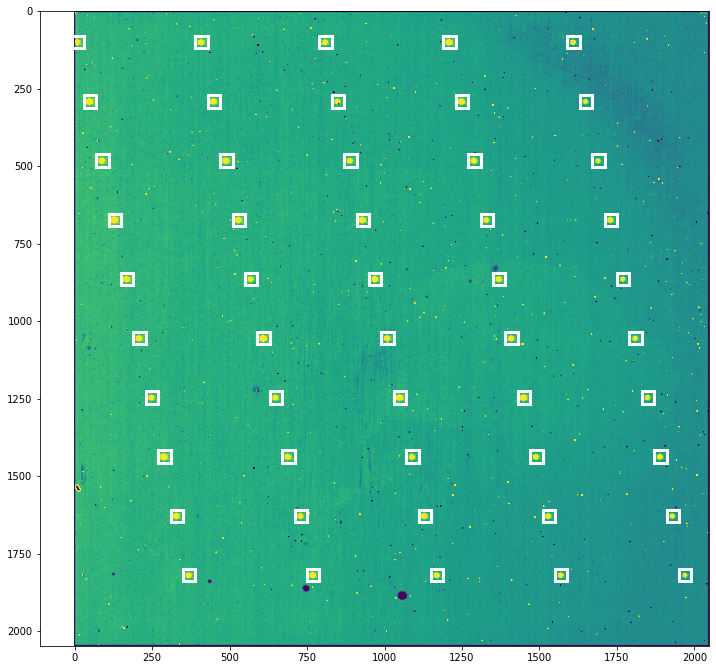

In [19]:
# Display image

show_image(image_dm.data,plt_srcs=True, x_pix=ptsrc_list['pixel_x'], y_pix=ptsrc_list['pixel_y'])

Convert from World to detector coordinates and compare with input detector coordinates

In [20]:
world_to_detector = gwcs.meta.wcs.get_transform('world', 'detector')

det = world_to_detector(ptsrc_list['RA_degrees'], ptsrc_list['DEC_degrees'])

del_x = det[0] - ptsrc_list['pixel_x']
del_y = det[1] - ptsrc_list['pixel_y']

del_x_rms = np.sqrt(np.mean(del_x**2))
del_y_rms = np.sqrt(np.mean(del_y**2))

print('RMS of delta-x is {0:.4f} and RMS of delta-Dy is {1:.4f}'.format(
del_x_rms, del_y_rms))

RMS of delta-x is 0.0057 and RMS of delta-Dy is 0.0047


Plot distribution of $\Delta$x and $\Delta$y

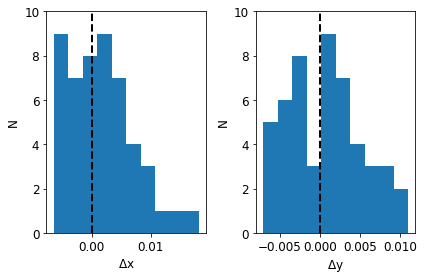

In [21]:
# Set up plot
fig,(ax1, ax2) = plt.subplots(1,2)

# Plot delta-x histogram
x_hist = ax1.hist(del_x)
# Label plot
ax1.set_xlabel(r'$\Delta$x',fontsize=12)
ax1.set_ylabel('N',fontsize=12)
# Set plot limits
ax1_yup = np.max(x_hist[0]) + 1
ax1.set_ylim(0, ax1_yup)
# plot line at zero
ax1.plot([0,0],[0,ax1_yup], '--', lw=2, c='black')
ax1.tick_params(labelsize=12)

# Plot delta-Dec histogram
y_hist = ax2.hist(del_y)
# Label plot
ax2.set_xlabel(r'$\Delta$y',fontsize=12)
ax2.set_ylabel('N',fontsize=12)
# Set plot limits
ax2_yup = np.max(y_hist[0]) + 1
ax2.set_ylim(0, ax2_yup)
# plot line at zero
ax2.plot([0,0],[0,ax2_yup], '--', lw=2, c='black')
ax2.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

Plot $\Delta$x and $\Delta$y as function of inputted x and y. Symbol & color-code based on detector position.

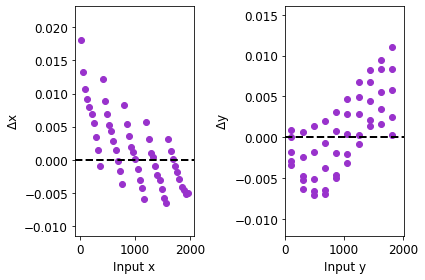

In [22]:
# Set up plot
fig,(ax1, ax2) = plt.subplots(1,2)

# Plot delta-x as function of input x
ax1.scatter(ptsrc_list['pixel_x'], del_x, marker='o', color='darkorchid')

# Label plot
ax1.set_ylabel(r'$\Delta$x',fontsize=12)
ax1.set_xlabel('Input x',fontsize=12)
# Set bounds on plot
xlo = np.min(ptsrc_list['pixel_x']) - 100
xhi = np.max(ptsrc_list['pixel_x']) + 100
ax1.set_xlim(xlo, xhi)
ax1.set_ylim(np.min(del_x) - 0.005,
             np.max(del_x) + 0.005)

# Plot horizontal line at 0
ax1.plot([xlo, xhi],[0,0], '--', lw=2, color='black')
ax1.tick_params(labelsize=12)


# Plot delta-y as function of input y
ax2.scatter(ptsrc_list['pixel_y'], del_y, marker='o', color='darkorchid')

# Label plot
ax2.set_ylabel(r'$\Delta$y',fontsize=12)
ax2.set_xlabel('Input y',fontsize=12)
# Set bounds on plot
xlo = np.min(ptsrc_list['pixel_y'])-100
xhi = np.max(ptsrc_list['pixel_y'])+200
ax2.set_xlim(xlo, xhi)
ax2.set_ylim(np.min(del_y)-0.005,np.max(del_y)+0.005)
# Plot horizontal line at 0
ax2.plot([xlo, xhi],[0,0], '--', lw=2, color='black')
ax2.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

### Pass/Fail test report

In [23]:
if ( ((del_x_rms) < tol_pix_diff) &
     ((del_y_rms) < tol_pix_diff)):
    print('Test passed! HUZZAH!')
else:
    print('TEST FAILED') 

print()
print('Tolerance for RMS of delta-x and delta-y is {}\n'.format(tol_pix_diff))
print('RMS of Del-x is: {0:0.4f},\nmaximum del-x: {1:0.4f}, \nminimum del-x: {2:0.6f}'.format(
    del_x_rms, np.max(abs(del_x)), np.min(abs(del_x))))
print('\nRMS of Del-y is: {0:0.4f}, \nmaximum of del-y of {1:0.4f}, \nminium del-y: {2:0.6f}'.format(
    del_y_rms, np.max(abs(del_y)), np.min(abs(del_y))))

Test passed! HUZZAH!

Tolerance for RMS of delta-x and delta-y is 0.01

RMS of Del-x is: 0.0057,
maximum del-x: 0.0181, 
minimum del-x: 0.000049

RMS of Del-y is: 0.0047, 
maximum of del-y of 0.0110, 
minium del-y: 0.000001


<a id="about_ID"></a>
## About this Notebook
**Author:** S. LaMassa, NIRISS
<br>**Updated On:** 05/26/2021

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 